## This notebook will help you train a vanilla Point-Cloud AE with the basic architecture we used in our paper.
    (it assumes latent_3d_points is in the PYTHONPATH and the structural losses have been compiled)

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14571882881484241958
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 11326753997
locality {
  bus_id: 1
}
incarnation: 795328218205523421
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0"
]


In [2]:

import sys
sys.path.insert(0, "/home/ubuntu")

import os.path as osp

from latent_3d_points.src.ae_templates import mlp_architecture_ala_iclr_18, default_train_params
from latent_3d_points.src.autoencoder import Configuration as Conf
from latent_3d_points.src.point_net_ae import PointNetAutoEncoder

from latent_3d_points.src.in_out import snc_category_to_synth_id, create_dir, PointCloudDataSet, \
                                        load_all_point_clouds_under_folder, pickle_data, unpickle_data

from latent_3d_points.src.tf_utils import reset_tf_graph
from latent_3d_points.src.general_utils import plot_3d_point_cloud

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Define Basic Parameters

In [4]:
top_out_dir = '../data/'          # Use to save Neural-Net check-points etc.
top_in_dir = '../data/shape_net_core_uniform_samples_2048/' # Top-dir of where point-clouds are stored.

experiment_name = 'single_class_incomplete_ae'
n_pc_points = 2048                # Number of points per model.
bneck_size = 128                  # Bottleneck-AE size
ae_loss = 'chamfer'                   # Loss to optimize: 'emd' or 'chamfer'
# class_name = raw_input('Give me the class name (e.g. "chair"): ').lower()
class_name = 'chair'

Load Point-Clouds

In [5]:
val_pkl = unpickle_data('/home/ubuntu/latent_3d_points/data/missing_points_dataset/val_data.pkl')
val_data = next(val_pkl)

Load default training parameters (some of which are listed beloq). For more details please print the configuration object.

    'batch_size': 50   
    
    'denoising': False     (# by default AE is not denoising)

    'learning_rate': 0.0005

    'z_rotate': False      (# randomly rotate models of each batch)
    
    'loss_display_step': 1 (# display loss at end of these many epochs)
    'saver_step': 10       (# over how many epochs to save neural-network)

In [6]:
train_params = default_train_params()

In [7]:
encoder, decoder, enc_args, dec_args = mlp_architecture_ala_iclr_18(n_pc_points, bneck_size)
train_dir = create_dir(osp.join(top_out_dir, experiment_name))

In [8]:
conf = Conf(n_input = [1948, 3],
            loss = ae_loss,
            training_epochs = train_params['training_epochs'],
            batch_size = train_params['batch_size'],
            denoising = train_params['denoising'],
            learning_rate = train_params['learning_rate'],
            train_dir = train_dir,
            loss_display_step = train_params['loss_display_step'],
            saver_step = train_params['saver_step'],
            z_rotate = train_params['z_rotate'],
            encoder = encoder,
            decoder = decoder,
            encoder_args = enc_args,
            decoder_args = dec_args,
            n_output = [2048, 3]
           )
conf.experiment_name = experiment_name
conf.held_out_step = 5   # How often to evaluate/print out loss on 
                         # held_out data (if they are provided in ae.train() ).
conf.save(osp.join(train_dir, 'configuration'))

If you ran the above lines, you can reload a saved model like this:

In [9]:
load_pre_trained_ae = True
restore_epoch = 400
if load_pre_trained_ae:
    conf = Conf.load(train_dir + '/configuration')
    reset_tf_graph()
    ae = PointNetAutoEncoder(conf.experiment_name, conf)
    ae.restore_model(conf.train_dir, epoch=restore_epoch)

Building Encoder
encoder_conv_layer_0 conv params =  256 bnorm params =  128
Tensor("single_class_incomplete_ae_2/Relu:0", shape=(?, 1948, 64), dtype=float32)
output size: 124672 

encoder_conv_layer_1 conv params =  8320 bnorm params =  256
Tensor("single_class_incomplete_ae_2/Relu_1:0", shape=(?, 1948, 128), dtype=float32)
output size: 249344 

encoder_conv_layer_2 conv params =  16512 bnorm params =  256
Tensor("single_class_incomplete_ae_2/Relu_2:0", shape=(?, 1948, 128), dtype=float32)
output size: 249344 

encoder_conv_layer_3 conv params =  33024 bnorm params =  512
Tensor("single_class_incomplete_ae_2/Relu_3:0", shape=(?, 1948, 256), dtype=float32)
output size: 498688 

encoder_conv_layer_4 conv params =  32896 bnorm params =  256
Tensor("single_class_incomplete_ae_2/Relu_4:0", shape=(?, 1948, 128), dtype=float32)
output size: 249344 

Tensor("single_class_incomplete_ae_2/Max:0", shape=(?, 128), dtype=float32)
Building Decoder
decoder_fc_0 FC params =  33024 Tensor("single_clas

Get a batch of reconstuctions and their latent-codes.

In [11]:
batch_i, feed_model_names, _ = val_data.next_batch(10)
batch_i, original_data = batch_i[:, :1948, :], batch_i[:, 1948:, :]
reconstructions = ae.reconstruct(batch_i)[0]
latent_codes = ae.transform(batch_i)

Use any plotting mechanism such as matplotlib to visualize the results.

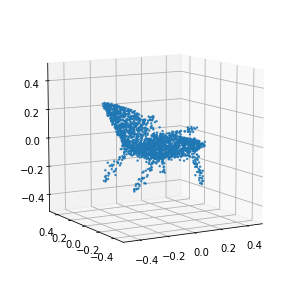

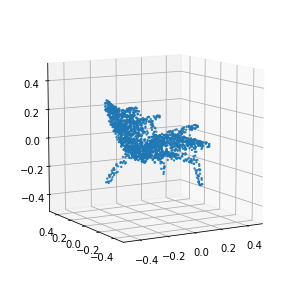

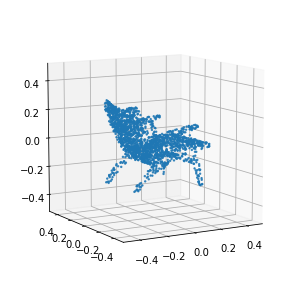

In [15]:
i = 5


plot_3d_point_cloud(reconstructions[i][:, 0], 
                    reconstructions[i][:, 1], 
                    reconstructions[i][:, 2], in_u_sphere=True);

plot_3d_point_cloud(batch_i[i][:, 0], 
                    batch_i[i][:, 1], 
                    batch_i[i][:, 2], in_u_sphere=True);

plot_3d_point_cloud(original_data[i][:, 0], 
                    original_data[i][:, 1], 
                    original_data[i][:, 2], in_u_sphere=True);


